<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">User Frustration Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine if a user became frustrated during a conversation with an AI assistant.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted user frustration detection
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qqq "arize-phoenix" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [3]:
!pip -qqq install 'arize-phoenix[evals]'

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.evals import (
    USER_FRUSTRATION_PROMPT_RAILS_MAP,
    USER_FRUSTRATION_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

/Users/jasonlopatecki/vs_projects/haystack-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
USER_FRUSTRATION_PROMPT_RAILS_MAP

OrderedDict([(True, 'frustrated'), (False, 'ok')])

## Download Benchmark Dataset (need to add this dataset to repo)

In [6]:
df = pd.read_parquet(
    "https://storage.googleapis.com/arize-assets/phoenix/evals/user_frustration-classification/example-user-frustration-dataset.parquet"
)
df.head()

,conversation,frustrated
0,"CUSTOMER: Hi, I seem to be having trouble with my internet service. It's been cutting in and out all morning.\n\nASSISTANT: I'm sorry to hear that you're experiencing this issue. Can you tell me more about the problem?\n\nCUSTOMER: It keeps disconnecting, despite resetting the modem multiple times. I've been trying to work online and it's becoming increasingly frustrating.\n\nASSISTANT: I appreciate your patience. Have you tried performing a speed test on your connection?\n\nCUSTOMER: Yes, I have. The results were all over the place, there's clearly instability. Can I speak to a live customer service rep about this?\n\nASSISTANT: Of course, let me connect you to our live support team who will be able to assist you further.",True
1,"CUSTOMER: Hi, I am experiencing some issues with the software I recently subscribed to. \n\nASSISTANT: I'm sorry to hear that you are having trouble. Can you describe the problem you're facing?\n\nCUSTOMER: Well, I am unable to sign in. The system does not recognize my email or password.\n\nASSISTANT: That's odd. I'm sure we can figure this out. Can you please confirm your email? \n\nCUSTOMER: Look, I don't think you get it. I did not receive the confirmation email you promised at registration. That is the issue!\n\nASSISTANT: I apologize for this oversight. I'll ensure the email is sent immediately. Please, check your inbox shortly.",True
2,"CUSTOMER: Hi, I'm having issues with my insurance policy claim.\n\nASSISTANT: I'm sorry to hear you're having trouble. Can you elaborate on the issue?\n\nCUSTOMER: Well, I submitted my claim two weeks ago and haven't received any updates yet.\n\nASSISTANT: I understand your concern. Let me check the status of your claim.\n\nCUSTOMER: I have been waiting for a while, can I speak with a live customer service representative instead?\n\nASSISTANT: Absolutely, allow me to connect you to a live agent who can assist you further.",True
3,"CUSTOMER: Hi, I'm having problems with your online booking service.\n\nASSISTANT: I'm sorry to hear that you are having issues. Can you elaborate on what's happening?\n\nCUSTOMER: Well, the system is not letting me sign in to complete a reservation.\n\nASSISTANT: I see, have you tried using the 'Forgot Password' option to reset your password?\n\nCUSTOMER: I've done that twice now and I'm still unable to sign in.\n\nASSISTANT: My apologies for the inconvenience. Would you like me to connect you with a live customer service representative?\n",True
4,"CUSTOMER: Hi, my new Fitness Band isn't tracking my heart rate correctly. \n\nASSISTANT: Can you elaborate on the problem that is occurring with the heart rate tracker? \n\nCUSTOMER: Yes, the numbers are fluctuating way too much. It got up to 190 bpm during a light jog.\n\nASSISTANT: Have you tried resetting the band? \n\nCUSTOMER: Yes, several times actually. Nothing seems to resolve this. Can I please speak directly with someone who can handle this?\n\nASSISTANT: Of course, I'm sorry for your inconvenience. Let me connect you with our technical support team.\n",True


## Phoenix UI (link) for Evals Debugging!!
Click the link below to see Evals in Phoenix UI. Runs locally on Colab Server and collects OpenAI calls as they are made by the Evals Library.

In [7]:
from phoenix.trace.openai import OpenAIInstrumentor

In [8]:
import phoenix as px

session = px.launch_app()
OpenAIInstrumentor().instrument()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


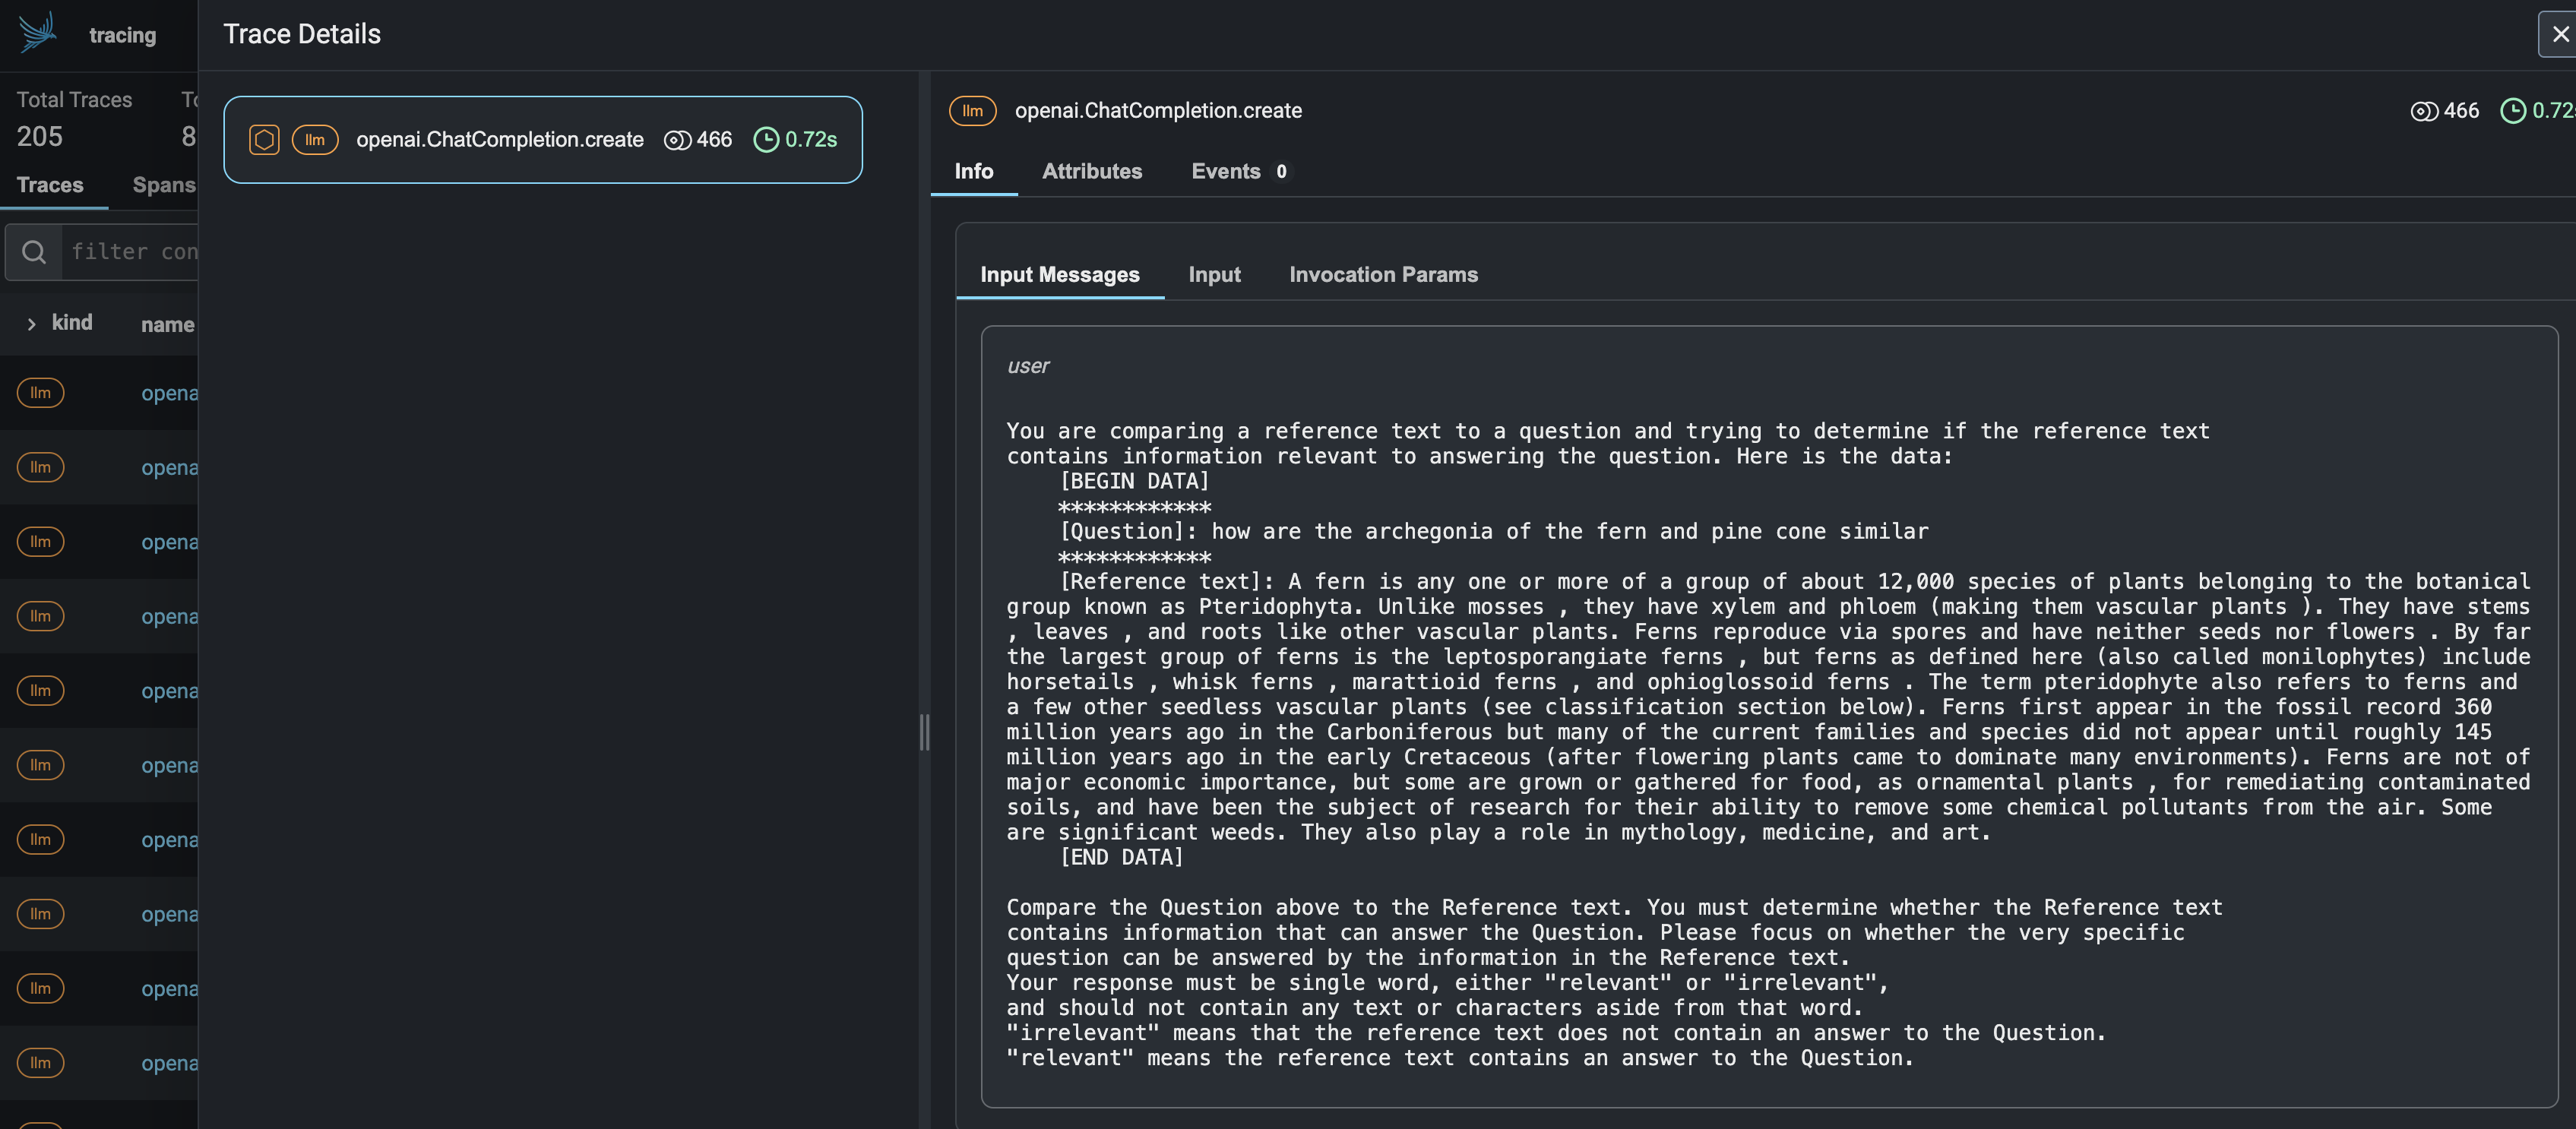

## Display User Frustration Classification Template (Need to add below template to repo)

View the default template used to classify user frustration. You can tweak this template and evaluate its performance relative to the default.


In [9]:
print(USER_FRUSTRATION_PROMPT_TEMPLATE)


  You are given a conversation where between a user and an assistant.
  Here is the conversation:
  [BEGIN DATA]
  *****************
  Conversation:
  {conversation}
  *****************
  [END DATA]

  Examine the conversation and determine whether or not the user got frustrated from the experience.
  Frustration can range from midly frustrated to extremely frustrated. If the user seemed frustrated
  at the beginning of the conversation but seemed satisfied at the end, they should not be deemed
  as frustrated. Focus on how the user left the conversation.

  Your response must be a single word, either "frustrated" or "ok", and should not
  contain any text or characters aside from that word. "frustrated" means the user was left
  frustrated as a result of the conversation. "ok" means that the user did not get frustrated
  from the conversation.



The template variables are:

- **conversation:** the chat conversation between a user and an assistant.

## Configure the LLM

Configure your OpenAI API key.

In [10]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time. It's recommended to start with a small sample (e.g., 100 data points) and iterate from there.

In [11]:
df_sample = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df_sample.shape

(100, 2)

## LLM Evals: User Frustration Classifications GPT-4
Run user frustration classifications against a subset of the data.
Instantiate the LLM and set parameters.

In [12]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [13]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run User Frustration Classifications

Run user frustration classifications against a subset of the data.

Verbose mode is active below, it will print out RateLimit handeling and rails
(railing / cleaning up the text ouptut to fixed values)

Rails will take a messy text output like "frustrated..." -> "frustrated"


In [14]:
import nest_asyncio

nest_asyncio.apply()

In [15]:
USER_FRUSTRATION_PROMPT_RAILS_MAP

OrderedDict([(True, 'frustrated'), (False, 'ok')])

In [21]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(USER_FRUSTRATION_PROMPT_RAILS_MAP.values())

frustration_classifications = llm_classify(
    dataframe=df_sample,
    template=USER_FRUSTRATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:03<00:00 | 28.89it/s


## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth user frustration labels.

              precision    recall  f1-score   support

  frustrated       1.00      0.80      0.89        49
          ok       0.84      1.00      0.91        51

    accuracy                           0.90       100
   macro avg       0.92      0.90      0.90       100
weighted avg       0.92      0.90      0.90       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

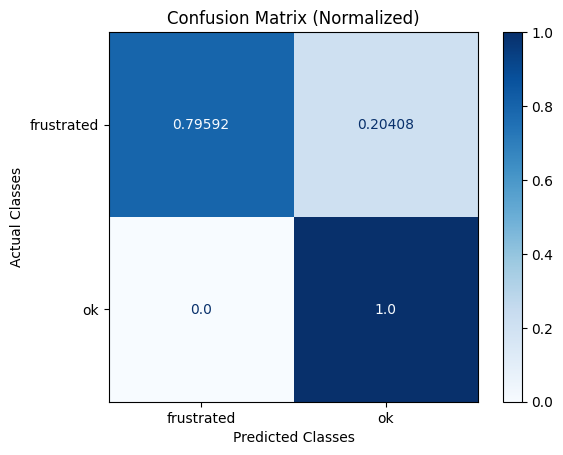

In [17]:
true_labels = df_sample["frustrated"].map(USER_FRUSTRATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, frustration_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=frustration_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## LLM Evals: User Frustration Classifications GPT-3.5
Run user frustration classifications against a subset of the data using GPT-3.5.

In [18]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [19]:
rails = list(USER_FRUSTRATION_PROMPT_RAILS_MAP.values())

frustration_classifications = llm_classify(
    dataframe=df_sample,
    template=USER_FRUSTRATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    verbose=False,
)["label"].tolist()

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:19<00:00 |  5.13it/s


              precision    recall  f1-score   support

  frustrated       0.98      0.96      0.97        49
          ok       0.96      0.98      0.97        51

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

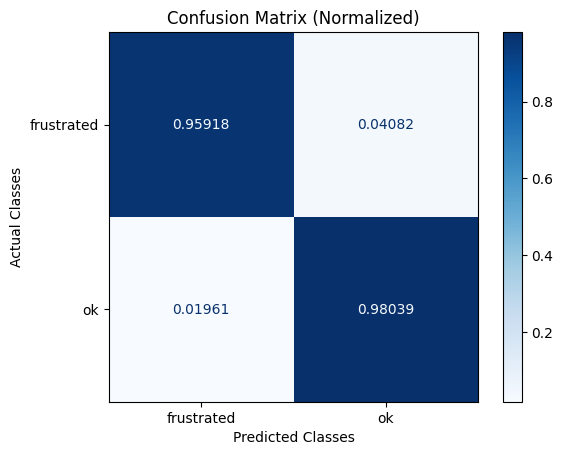

In [20]:
true_labels = df_sample["frustrated"].map(USER_FRUSTRATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, frustration_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=frustration_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)